In [7]:
!pip install tensorflow
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from google.colab import drive
import os

In [8]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
base_path = '/content/drive/My Drive/Colab Notebooks/Project'
json_file = os.path.join(base_path, 'Sarcasm_Headlines_Dataset_v2.json')
csv_file = os.path.join(base_path, 'input_dataset.csv')
glove_file = os.path.join(base_path, 'glove.6B.100d.txt')

In [10]:
print("Sample Data from Sarcasm_Headlines_Dataset_v2.json")
print("Sample headlines and sarcasm labels from original dataset.")
print("-" * 40)
df_json = pd.read_json(json_file, lines=True)
print(df_json.head(5))


Sample Data from Sarcasm_Headlines_Dataset_v2.json
Sample headlines and sarcasm labels from original dataset.
----------------------------------------
   is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  
0  https://www.theonion.com/thirtysomething-scien...  
1  https://www.huffingtonpost.com/entry/donna-edw...  
2  https://www.huffingtonpost.com/entry/eat-your-...  
3  https://local.theonion.com/inclement-weather-p...  
4  https://www.theonion.com/mother-comes-pretty-c...  


In [11]:
#Load input dataset

df = pd.read_csv(csv_file)
df_subset = df.sample(frac=0.5, random_state=42)
print("\nNumber of rows:", len(df_subset))
print("Columns:", df_subset.columns)

if df_subset.empty:
    raise ValueError("No valid data loaded")


Number of rows: 5148
Columns: Index(['headline', 'data', 'target', 'article_link'], dtype='object')


In [12]:
# load glove embeddings

def load_glove_embeddings(glove_file, word_index, embedding_dim=100):
    embeddings_index = {}
    with open(glove_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, vocab_size

In [13]:
# Preprocess text

def preprocess_text(texts):
    word_counts = texts.str.split().str.len()
    max_len = int(max(word_counts))
    tokenizer = Tokenizer(oov_token='<OOV>')
    tokenizer.fit_on_texts(texts)
    vocab_size = len(tokenizer.word_index) + 1
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    return padded_sequences, tokenizer.word_index, max_len, vocab_size

In [14]:
# build Bi-LSTM model

def build_bilstm_model(vocab_size, embedding_dim, max_len, embedding_matrix):
    input_layer = Input(shape=(max_len,))
    embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)
    bilstm = Bidirectional(LSTM(32))(embedding)
    dropout = Dropout(0.5)(bilstm)
    dense = Dense(16, activation='relu')(dropout)
    output = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [15]:
# train on headline

print("\nTraining Bi-LSTM on Headline")
print("-" * 40)
texts_h = df_subset['headline']
labels = df_subset['target'].values
X_h, word_index_h, max_len_h, vocab_size_h = preprocess_text(texts_h)
embedding_matrix_h, vocab_size_h = load_glove_embeddings(glove_file, word_index_h)
print(f"Parameters: max_len={max_len_h}, vocab_size={vocab_size_h}, batch_size=32")
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_h, labels, test_size=0.2, random_state=42)
model_h = build_bilstm_model(vocab_size_h, 100, max_len_h, embedding_matrix_h)
history_h = model_h.fit(X_train_h, y_train_h, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
y_pred_h = (model_h.predict(X_test_h) > 0.5).astype(int)
print("\nHeadline Bi-LSTM Classification Report:")
report_h = classification_report(y_test_h, y_pred_h, target_names=['Non-Sarcastic', 'Sarcastic'], output_dict=True)
print(classification_report(y_test_h, y_pred_h, target_names=['Non-Sarcastic', 'Sarcastic']))
h_acc = report_h['accuracy']
h_loss = model_h.evaluate(X_test_h, y_test_h, verbose=0)[0]


Training Bi-LSTM on Headline
----------------------------------------
Parameters: max_len=27, vocab_size=12231, batch_size=32
Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.5209 - loss: 0.6941 - val_accuracy: 0.6687 - val_loss: 0.6214
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6921 - loss: 0.5901 - val_accuracy: 0.7269 - val_loss: 0.5292
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7701 - loss: 0.4915 - val_accuracy: 0.7609 - val_loss: 0.4881
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8005 - loss: 0.4399 - val_accuracy: 0.7828 - val_loss: 0.4600
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8376 - loss: 0.3786 - val_accuracy: 0.7913 - val_loss: 0.4364
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8611 - loss: 0.3404 - val_accuracy: 0.7998 - val_loss: 0.4251
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8742 - loss: 0.3158 - val_accura

In [16]:
# train on headline + full article

print("\nTraining Bi-LSTM on Headline + Full Article")
print("-" * 40)
texts_d = df_subset['headline'] + " " + df_subset['data']
X_d, word_index_d, max_len_d, vocab_size_d = preprocess_text(texts_d)
embedding_matrix_d, vocab_size_d = load_glove_embeddings(glove_file, word_index_d)
print(f"Parameters: max_len={max_len_d}, vocab_size={vocab_size_d}, batch_size=32")
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, labels, test_size=0.2, random_state=42)
model_d = build_bilstm_model(vocab_size_d, 100, max_len_d, embedding_matrix_d)
history_d = model_d.fit(X_train_d, y_train_d, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
y_pred_d = (model_d.predict(X_test_d) > 0.5).astype(int)
print("\nHeadline + Full Article Bi-LSTM Classification Report:")
report_d = classification_report(y_test_d, y_pred_d, target_names=['Non-Sarcastic', 'Sarcastic'], output_dict=True)
print(classification_report(y_test_d, y_pred_d, target_names=['Non-Sarcastic', 'Sarcastic']))
d_acc = report_d['accuracy']
d_loss = model_d.evaluate(X_test_d, y_test_d, verbose=0)[0]


Training Bi-LSTM on Headline + Full Article
----------------------------------------
Parameters: max_len=6260, vocab_size=69567, batch_size=32
Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 440s 4s/step - accuracy: 0.5744 - loss: 0.6745 - val_accuracy: 0.7670 - val_loss: 0.5216
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 456s 4s/step - accuracy: 0.7738 - loss: 0.4913 - val_accuracy: 0.7233 - val_loss: 0.5402
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 447s 4s/step - accuracy: 0.8209 - loss: 0.4022 - val_accuracy: 0.8216 - val_loss: 0.4047
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 501s 4s/step - accuracy: 0.8889 - loss: 0.2878 - val_accuracy: 0.9102 - val_loss: 0.2397
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 500s 4s/step - accuracy: 0.9114 - loss: 0.2363 - val_accuracy: 0.9260 - val_loss: 0.2146
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 503s 4s/step - accuracy: 0.9328 - loss: 0.1848 - val_accuracy: 0.9223 - val_loss: 0.2200
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/step - accuracy: 0.9218 - loss: 0.

In [17]:
# Compare performance

print("\nPerformance Comparison: Headline vs Headline + Full Article")
print("-" * 40)
comparison_df = pd.DataFrame({
    'Model': ['Headline', 'Headline + Full Article'],
    'Test Accuracy': [h_acc, d_acc]
})
print(comparison_df)


Performance Comparison: Headline vs Headline + Full Article
----------------------------------------
                     Model  Test Accuracy
0                 Headline       0.818447
1  Headline + Full Article       0.954369


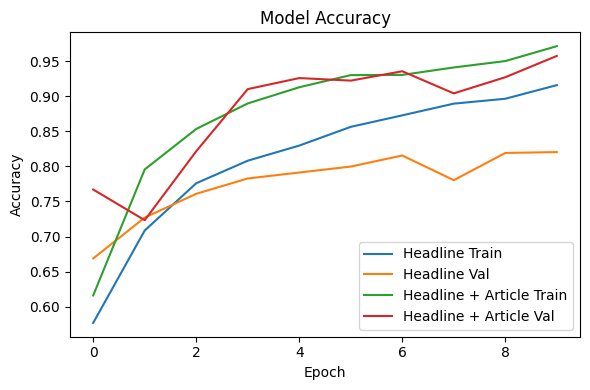

In [18]:
# model accuracy

plt.figure(figsize=(6, 4))
plt.plot(history_h.history['accuracy'], label='Headline Train')
plt.plot(history_h.history['val_accuracy'], label='Headline Val')
plt.plot(history_d.history['accuracy'], label='Headline + Article Train')
plt.plot(history_d.history['val_accuracy'], label='Headline + Article Val')

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
